In [1]:
#importing libraries
import pandas as pd #pandas for data loading and manipulation
import numpy as np #numpy for numerical operation


In [3]:
# Loading and inspecting the data
df = pd.read_csv("quikr_car.csv") #Reads datasets into df
df['year'].unique() #unique() shows what value exists in year and price columns
df['Price'].unique()


array(['80,000', '4,25,000', 'Ask For Price', '3,25,000', '5,75,000',
       '1,75,000', '1,90,000', '8,30,000', '2,50,000', '1,82,000',
       '3,15,000', '4,15,000', '3,20,000', '10,00,000', '5,00,000',
       '3,50,000', '1,60,000', '3,10,000', '75,000', '1,00,000',
       '2,90,000', '95,000', '1,80,000', '3,85,000', '1,05,000',
       '6,50,000', '6,89,999', '4,48,000', '5,49,000', '5,01,000',
       '4,89,999', '2,80,000', '3,49,999', '2,84,999', '3,45,000',
       '4,99,999', '2,35,000', '2,49,999', '14,75,000', '3,95,000',
       '2,20,000', '1,70,000', '85,000', '2,00,000', '5,70,000',
       '1,10,000', '4,48,999', '18,91,111', '1,59,500', '3,44,999',
       '4,49,999', '8,65,000', '6,99,000', '3,75,000', '2,24,999',
       '12,00,000', '1,95,000', '3,51,000', '2,40,000', '90,000',
       '1,55,000', '6,00,000', '1,89,500', '2,10,000', '3,90,000',
       '1,35,000', '16,00,000', '7,01,000', '2,65,000', '5,25,000',
       '3,72,000', '6,35,000', '5,50,000', '4,85,000', '3,29,5

In [4]:
#cleaning year and price columns
df = df[df['year'].str.isnumeric()] #Drop rows where year is not numeric
df = df[df['Price'] != 'Ask For Price'] #Remove rows where price says"Ask for price"
df['Price'] = df['Price'].str.replace(",", "").astype(int) #clean price string by removing commas and converting it to numeric


In [5]:
# Cleaning kilometer driven
df['kms_driven'] = df['kms_driven'].str.split(" ").str.get(0).str.replace(",", "") #split km_driven at spaces and keep the first part(the numbers)
df = df[df['kms_driven'].str.isnumeric()] #removing commas
df['kms_driven'] = df['kms_driven'].astype(int) #Convert to integer type


In [6]:
#Droping rows missing key categories
df = df[~df['fuel_type'].isna()] #Removing any rows missing fuel_type


In [8]:
#Simplifying the car name
df['name'] = df['name'].str.split(" ").str.slice(0,3).str.join(" ") #Trims the name to first three categories to reduce unique categories


In [10]:
#Filters and resetting index
df = df.reset_index(drop=True)#resetting row indices for a clean dataframe
df = df[df['Price'] < 6e6].reset_index(drop=True) #removing prices over 6millions to avoid extreme values
df.to_csv("safe.csv") #saving the clean datasets


In [11]:
#Preparing features and targets
X = df.drop(columns="Price") #x:all colums expect price columns
y = df["Price"] #y:only price column


In [12]:
#Splitting data into training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#Splitting data into 80%training and 20% testing data to evaluate model performance


In [13]:
#Encoding categorial variables into numbers 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

ohe = OneHotEncoder()
ohe.fit(X[['name','company','fuel_type']])
#Creating an encoder for columns name,company and fuel_type

OneHotEncoder()

In [15]:
#Building a transformer where oneHot encodes those categorical colums and passes the numerical columns unchanged
transformer = make_column_transformer(
  (OneHotEncoder(categories=ohe.categories_), ['name','company','fuel_type']),
  remainder='passthrough'
)


In [16]:
#Creating and training the model pipeline
from sklearn.linear_model import LinearRegression
lr = LinearRegression() #Using the linear regression model
pipe = make_pipeline(transformer, lr) #Combines encoding and model into one pipeline then trains it
pipe.fit(x_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['Audi A3 Cabriolet', 'Audi A4 1.8', 'Audi A4 2.0', 'Audi A6 2.0',
       'Audi A8', 'Audi Q3 2.0', 'Audi Q5 2.0', 'Audi Q7', 'BMW 3 Series',
       'BMW 5 Series', 'BMW 7 Series', 'BMW X1', 'BMW X1 sDrive20d',
       'BMW X1 xDrive20d', 'Chevrolet Beat', 'Chevrolet Beat...
                                                                            array(['Audi', 'BMW', 'Chevrolet', 'Datsun', 'Fiat', 'Force', 'Ford',
       'Hindustan', 'Honda', 'Hyundai', 'Jaguar', 'Jeep', 'Land',
       'Mahindra', 'Maruti', 'Mercedes', 'Mini', 'Mitsubishi', 'Nissan',
       'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen', 'Volvo'],
      dtype=object),
                                                                            array(['Diesel', 'LPG', 'Petrol'], dtype=object)]),
                                                  ['name', 'company',
                                                   'fuel_type'])])),
                ('linearregression', LinearRegression())])

In [17]:
#Evaluating the performance
y_pred = pipe.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)
#Predicts on test set and computes R² score to evaluate how well the model fits

0.6886315071867377

In [18]:
#Finding best random split 
results = []
for i in range(500):
    x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=i)
    lr = LinearRegression()
    pipe = make_pipeline(transformer, lr)
    pipe.fit(x_tr, y_tr)
    pred = pipe.predict(x_te)
    results.append(r2_score(y_te, pred))
np.argmax(results)


433

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=433)


In [20]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

pipe = make_pipeline(transformer, rf)
pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)
print("R2 Score:", r2_score(y_test, y_pred))


R2 Score: 0.8255592595344233


In [21]:
#Saving the regression model
import pickle
pickle.dump(pipe, open('LRModel.pkl', 'wb'))


In [22]:
#Save the Random Forest model
import pickle
pickle.dump(pipe, open('RandomForestModel.pkl', 'wb'))


In [23]:
#Predict for a new sample
sample = pd.DataFrame([['Hyundai Santro Xing','Hyundai',2010,45000,'Petrol']],
           columns=['name','company','year','kms_driven','fuel_type'])

print("Predicted Price:", pipe.predict(sample))


Predicted Price: [130409.87]


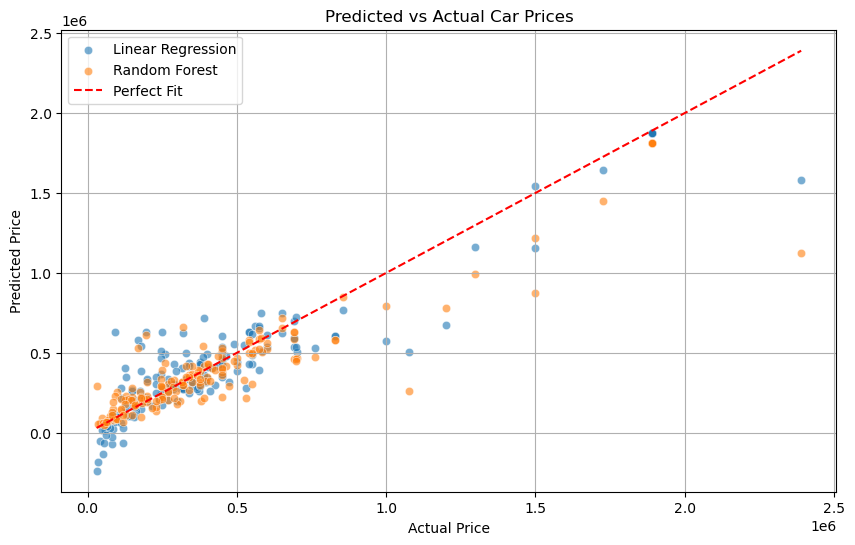

In [25]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Linear Regression model and prediction
lr = LinearRegression()
pipe_lr = make_pipeline(transformer, lr)
pipe_lr.fit(x_train, y_train)
y_pred_lr = pipe_lr.predict(x_test)

# Random Forest predictions 

# Plot both predictions
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred_lr, label="Linear Regression", alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred, label="Random Forest", alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Car Prices")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [29]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


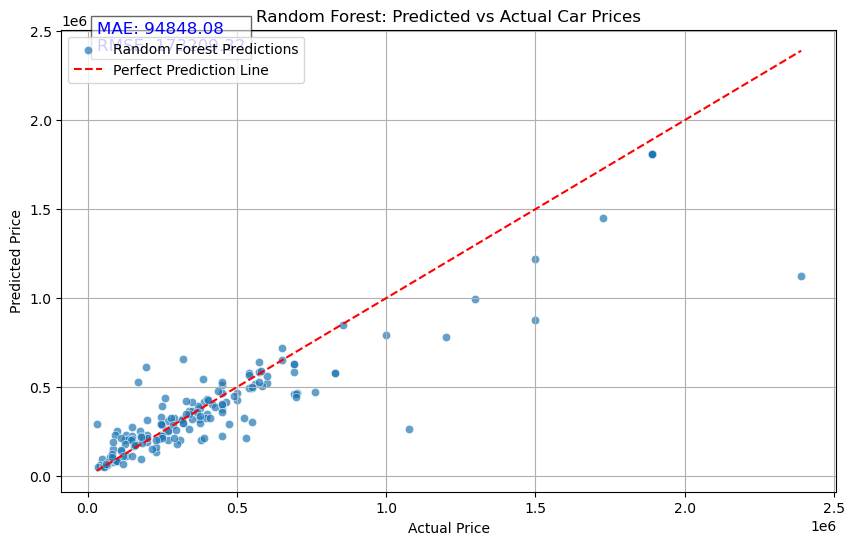

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Plot predicted vs actual
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, label="Random Forest Predictions", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')

# Show error values on the plot
plt.text(
    x=y_test.min(), 
    y=y_test.max(), 
    s=f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}',
    fontsize=12,
    color='blue',
    bbox=dict(facecolor='white', alpha=0.6)
)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Predicted vs Actual Car Prices")
plt.legend()
plt.grid(True)
plt.show()
